#### Computational Methods in Finance Project 4

Xinlin Yuan

In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm
import math
import importlib
import function
importlib.reload(function)
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

#### Question 1

In [2]:
def combos(n, i):
    return math.factorial(n) / (math.factorial(n-i)*math.factorial(i))

In [3]:
r = 0.05
t = 0.5
s0 = 32
k = 30
sigma = 0.24

In [4]:
# a
def binom_e_call_1(s0, k, r, t, sigma, n):
    dt = t/n
    c = (np.exp(-r*dt) + np.exp((r+sigma**2)*dt)) / 2
    d = c - np.sqrt(c**2 - 1)
    u = 1/d
    p = (np.exp(r*dt)-d) / (u-d)
    value = 0
    for i in range(n+1):
        node_prob = combos(n,i) * p**i * (1-p)**(n-i)
        st = s0 * u**i * d**(n-i)
        value += max(st-k,0) * node_prob
    return value * np.exp(-r*t)

n = [10,20,40,80,100,200,500]
price1 = []
for i in n:
    price1.append(binom_e_call_1(s0, k, r, t, sigma, i))

In [5]:
# b
def binom_e_call_2(s0, k, r, t, sigma, n):
    dt = t/n
    u = np.exp(r*dt) * (1 + np.sqrt(np.exp((sigma**2)*dt)-1))
    d = np.exp(r*dt) * (1 - np.sqrt(np.exp((sigma**2)*dt)-1))
    p = 1/2
    value = 0
    for i in range(n+1):
        node_prob = combos(n,i) * p**i * (1-p)**(n-i)
        st = s0 * u**i * d**(n-i)
        value += max(st-k,0) * node_prob
    return value * np.exp(-r*t)

n = [10,20,40,80,100,200,500]
price2 = []
for i in n:
    price2.append(binom_e_call_2(s0, k, r, t, sigma, i))

In [6]:
# c
def binom_e_call_3(s0, k, r, t, sigma, n):
    dt = t/n
    u = np.exp((r - sigma**2/2)*dt + sigma*np.sqrt(dt))
    d = np.exp((r - sigma**2/2)*dt - sigma*np.sqrt(dt))
    p = 1/2
    value = 0
    for i in range(n+1):
        node_prob = combos(n,i) * p**i * (1-p)**(n-i)
        st = s0 * u**i * d**(n-i)
        value += max(st-k,0) * node_prob
    return value * np.exp(-r*t)

n = [10,20,40,80,100,200,500]
price3 = []
for i in n:
    price3.append(binom_e_call_3(s0, k, r, t, sigma, i))

In [7]:
# d
def binom_e_call_4(s0, k, r, t, sigma, n):
    dt = t/n
    u = np.exp(sigma*np.sqrt(dt))
    d = np.exp(-sigma*np.sqrt(dt))
    p = 1/2 + 1/2*((r-sigma**2/2)*np.sqrt(dt)/sigma)
    value = 0
    for i in range(n+1):
        node_prob = combos(n,i) * p**i * (1-p)**(n-i)
        st = s0 * u**i * d**(n-i)
        value += max(st-k,0) * node_prob
    return value * np.exp(-r*t)

n = [10,20,40,80,100,200,500]
price4 = []
for i in n:
    price4.append(binom_e_call_4(s0, k, r, t, sigma, i))

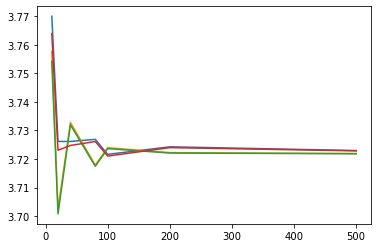

In [8]:
plt.figure(1)
plt.plot(n, price1)
plt.plot(n, price2)
plt.plot(n, price3)
plt.plot(n, price4)

#### Question 2

#### (a)

In [9]:
amzn = yf.Ticker('AMZN')
s0 = amzn.info['regularMarketPrice']
previous_close_price = amzn.info['regularMarketPreviousClose']
amzn_hist = amzn.history(start="2017-04-30", end="2022-04-29", interval="1d") # 60 months
amzn_hist['Log returns'] = np.log(amzn_hist['Close']/amzn_hist['Close'].shift())
sigma = amzn_hist['Log returns'].std()*252**.5

print('market price: $', s0)
print('previous close price: $', previous_close_price)
print('volatility:', sigma)

market price: $ 2485.63
previous close price: $ 2891.93
volatility: 0.3142586280807842


In [10]:
k0 = int(s0*1.1)
k_list = range(k0, k0+50, 1)
k = list(filter(lambda x: (x%50==0), k_list))
print("Strike Price (divisible by 50) is $", k)
# k = previous_close_price

Strike Price (divisible by 50) is $ [2750]


In [11]:
# american options
def binom_a(s0, k, r, t, sigma, n, type_):
    dt = t/n
    c = (np.exp(-r*dt) + np.exp((r+sigma**2)*dt)) / 2
    d = c - np.sqrt(c**2 - 1)
    u = 1/d
    p = (np.exp(r*dt)-d) / (u-d)
    
    # binomial price tree
    stockvalue = np.zeros((n+1, n+1))
    stockvalue[0, 0] = s0
    for i in range(1,n+1):
        stockvalue[i,0] = stockvalue[i-1,0]*u
        for j in range(1,i+1):
            stockvalue[i,j] = stockvalue[i-1,j-1]*d
    
    # option value at final node   
    optionvalue = np.zeros((n+1,n+1))
    for j in range(n+1):
        if type_=="call":
            optionvalue[n,j] = max(0, stockvalue[n,j]-k)
        elif type_=="put":
            optionvalue[n,j] = max(0, k-stockvalue[n,j])
    
    # backward calculation for option price    
    for i in range(n-1,-1,-1):
        for j in range(i+1):
                if type_=="put":
                    optionvalue[i,j] = max(0, k-stockvalue[i,j], \
                                           np.exp(-r*dt)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1]))
                elif type_=="call":
                    optionvalue[i,j] = max(0, stockvalue[i,j]-k, \
                                           np.exp(-r*dt)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1]))
    
    return optionvalue[0,0]

In [12]:
r = 0.01
t = 9/12 # expire in Jan 2023

print('Estimated option price is $', binom_a(s0, k, r, t, sigma, 100, 'call'))

Estimated option price is $ 176.74544322125675


Comment: The call option with strike price 2750 and expiration date 2023-01-20 is 219.19, which is higher than my estimation of $ 176.75. The difference may be resulted from the higher implied volatility.

#### (b)

In [13]:
binom_a(s0, k, r, t, 0.363565, 100, 'call')

219.1942125039088

Market price of 219.19 implies that the volatility is around 0.3636, which is higher than historical 60-months volatility of 0.3143.

#### Question 3

In [14]:
s0 = 49
k = 50
r = 0.03
sigma = 0.2
t = 0.3846
mu = 0.14
n = 100
dt = t/n

#### (i)

In [15]:
s0 = list(range(20, 82, 2))

D1 = []
for i in s0:
    d = (binom_e_call_1(i+dt,k,r,t,sigma,n) - binom_e_call_1(i-dt,k,r,t,sigma,n)) / (2*dt)
    D1.append(d)

#### (ii)

In [16]:
s0 = 49
T = list(range(0, 3846, 100))
t = []
for i in T:
    t.append(i/1000)

D2 = []
for i in t:
    d = (binom_e_call_1(s0+dt,k,r,i,sigma,n) - binom_e_call_1(s0-dt,k,r,i,sigma,n)) / (2*dt)
    D2.append(d)

#### (iii)

In [17]:
s0 = list(range(20, 82, 2))
t = 0.3846
T = []
for i in s0:
    theta = - (binom_e_call_1(i,k,t+dt,r,sigma,n) - binom_e_call_1(i,k,t-dt,r,sigma,n)) / (2*dt)
    T.append(theta)

#### (iv)

In [18]:
s0 = list(range(20, 82, 2))
G = []
for i in s0: 
    d1 = (binom_e_call_1(i+dt,k,t,r,sigma,n) - binom_e_call_1(i,k,t,r,sigma,n)) / dt
    d2 = (binom_e_call_1(i,k,t,r,sigma,n) - binom_e_call_1(i-dt,k,t,r,sigma,n)) / dt
    g = (d1 - d2) / dt
    G.append(g)

#### (v)

In [19]:
s0 = list(range(20, 82, 2))
V = []
for i in s0:
    vega = (binom_e_call_1(i,k,t,r,sigma+0.01,n) - binom_e_call_1(i,k,t,r,sigma,n)) / 0.01
    V.append(vega)

#### (vi)

In [20]:
s0 = list(range(20, 82, 2))
R = []
for i in s0:
    rho = (binom_e_call_1(i,k,t,r+0.0001,sigma,n) - binom_e_call_1(i,k,t,r,sigma,n)) / 0.0001
    R.append(rho)

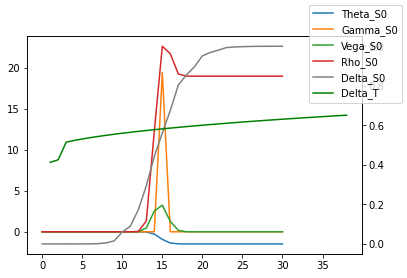

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(T, label='Theta_S0')
ax.plot(G, label='Gamma_S0')
ax.plot(V, label='Vega_S0')
ax.plot(R, label='Rho_S0')
ax1 = ax.twinx()
ax1.plot(D1, label='Delta_S0', color='grey')
ax1.plot(D2, label='Delta_T', color='green')
fig.legend()
plt.show()

#### Question 4

In [22]:
# european options
def binom_e(s0, k, r, t, sigma, n, type_='call'):
    dt = t/n
    c = (np.exp(-r*dt) + np.exp((r+sigma**2)*dt)) / 2
    d = c - np.sqrt(c**2 - 1)
    u = 1/d
    p = (np.exp(r*dt)-d) / (u-d)
    value = 0
    
    for i in range(n+1):
        node_prob = combos(n,i) * p**i * (1-p)**(n-i)
        st = s0 * u**i * d**(n-i)
        if type_ == 'call':
            value += max(st-k,0) * node_prob
        elif type_ == 'put':
            value += max(k-st,0) * node_prob
        else:
            raise ValueError("type_ must be 'call' or 'put'")
    
    return value * np.exp(-r*t)

In [23]:
# american options
def binom_a(s0, k, r, t, sigma, n, type_='call'):
    dt = t/n
    c = (np.exp(-r*dt) + np.exp((r+sigma**2)*dt)) / 2
    d = c - np.sqrt(c**2 - 1)
    u = 1/d
    p = (np.exp(r*dt)-d) / (u-d)
    
    # binomial price tree
    stockvalue = np.zeros((n+1, n+1))
    stockvalue[0, 0] = s0
    for i in range(1,n+1):
        stockvalue[i,0] = stockvalue[i-1,0]*u
        for j in range(1,i+1):
            stockvalue[i,j] = stockvalue[i-1,j-1]*d
    
    # option value at final node   
    optionvalue = np.zeros((n+1,n+1))
    for j in range(n+1):
        if type_=="call":
            optionvalue[n,j] = max(0, stockvalue[n,j]-k)
        elif type_=="put":
            optionvalue[n,j] = max(0, k-stockvalue[n,j])
    
    # backward calculation for option price    
    for i in range(n-1,-1,-1):
        for j in range(i+1):
                if type_=="put":
                    optionvalue[i,j] = max(0, k-stockvalue[i,j], \
                                           np.exp(-r*dt)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1]))
                elif type_=="call":
                    optionvalue[i,j] = max(0, stockvalue[i,j]-k, \
                                           np.exp(-r*dt)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1]))
    
    return optionvalue[0,0]

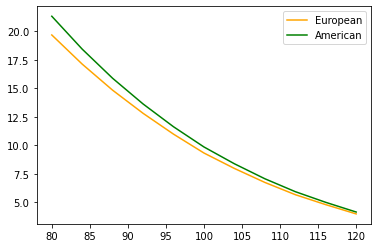

In [24]:
s0 = list(range(80, 124, 4))
k = 100
r = 0.05
t = 1
sigma = 0.3
n = 100

q4_e = []
for i in s0:
    q4_e.append(binom_e(i, k, r, t, sigma, n, type_='put'))
    
q4_a = []
for i in s0:
    q4_a.append(binom_a(i, k, r, t, sigma, n, type_='put'))

plt.figure(1)
plt.plot(s0, q4_e, label='European', color='orange')
plt.plot(s0, q4_a, label='American', color='green')
plt.legend()

Comments: Prices of American option are higher than that of European option.

#### Question 5

#### (a)

In [25]:
def tri(n, i, j):
    return math.factorial(n) / (math.factorial(n-i-j)*math.factorial(i)*math.factorial(j))

In [26]:
def trio_e_call(s0, k, t, r, sigma, n):
    dt = t/n
    d = np.exp(-sigma*np.sqrt(3*dt))
    u = 1/d
    m = 1 - d - u
    pd = (r*dt*(1-u) + (r*dt)**2 + (sigma**2)*dt) / ((u-d)*(1-d))
    pu = (r*dt*(1-d) + (r*dt)**2 + (sigma**2)*dt) / ((u-d)*(u-1))
    pm = 1 - pd - pu
    
    value = 0
    for i in range(n+1):
        for j in range(n-i+1):
            node_prob = tri(n, i, j)* pu**i * pm**(n-i-j) * pd**j
            st = s0 * u**i * m**(n-i-j) * d**j
            value += max(st-k,0) * node_prob
    
    return value * np.exp(-r*t)        

In [27]:
t = 0.5
r = 0.05
sigma = 0.24
s0 = 32
k = 30
n = [10, 15, 20, 40, 70, 80, 100, 200, 500]

In [28]:
tri_price = []
for i in n:
    tri_price.append(trio_e_call(s0, k, t, r, sigma, i))

#### (b)

In [29]:
def trio_e_logcall(s0, k, t, r, sigma, n):
    dt = t/n
    xu = sigma*np.sqrt(3*dt)
    xd = -xu
    pd = ( (sigma**2*dt + (r-sigma**2/2)**2 * dt**2)/xu**2 - (r-sigma**2/2)*dt/xu ) / 2
    pu = ( (sigma**2*dt + (r-sigma**2/2)**2 * dt**2)/xu**2 + (r-sigma**2/2)*dt/xu ) / 2
    pm = 1 - pu - pd
    
    value = 0
    for i in range(n+1):
        for j in range(n-i+1):
            node_prob = tri(n, i, j)* pu**i * pm**(n-i-j) * pd**j
            st = s0 + xu*i + xd*j
            value += max(st-k,0) * node_prob
    
    return value * np.exp(-r*t)

In [30]:
tri_logprice = []
for i in n:
    tri_logprice.append(trio_e_logcall(s0, k, t, r, sigma, i))

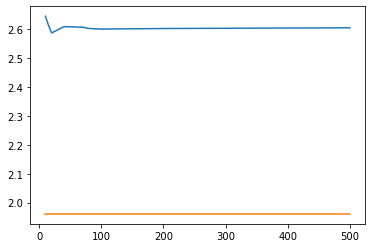

In [31]:
plt.figure(1)
plt.plot(n, tri_price)
plt.plot(n, tri_logprice)

#### Question 6

In [32]:
def getHalton(k,base):
    halton_base2 = []
    
    for i in range(1,k+1):
        a = list()
        while(i>0):
            res = i%base
            a.append(res)
            i = i-res
            i = i//base
        a = np.array(a)
        
        sum = 0
        for j in range(len(a)):
            sum = sum + a[j]/(base**(j+1))
       
        halton_base2.append(sum)
    return halton_base2

In [33]:
def halton_e_call(s0, k, t, r, sigma, n, base1, base2):
    H_base1 = getHalton(n, base1)
    H_base2 = getHalton(n, base2)
    df = pd.DataFrame(data={'h1':H_base1, 'h2':H_base2}).dropna(axis=0)
    h1 = df['h1']
    h2 = df['h2']
    z1 = np.sqrt(-2*np.log(h1)) * np.cos(2*np.pi*h2)
    z2 = np.sqrt(-2*np.log(h1)) * np.sin(2*np.pi*h2)
    value = max(s0*np.exp((r-sigma**2/2)*t + sigma*np.sqrt(t)*z1) - k, 0)
    return np.mean(value) * np.exp(-r*t)

In [ ]:
C = halton_e_call(32, 30, 0.5, 0.05, 0.24, 100, 2, 7)